# **Tanzanian Water Wells Prediction**

---


### **Authors:** [Abduba Galgalo](https://github.com/Abduba011), [Faith Makokha](https://github.com/faithmaks), [Femi Kamau](https://github.com/ctrl-Karugu), [John Mungai](https://github.com/Johnspes), [Susan Mungai](https://github.com/SueMungai), and [Willy Angole](https://github.com/Willy-Angole)

## 1. Business Understanding

## 2. Data Understanding

> This phase is broken down into four tasks together with its projected outcome or output in detail:
> - Collect Initial Data
> - Describe Data
> - Explore Data
> - Verify Data Quality

The data for this project was provided by our stakeholder, the World Health Organization. This data consists of information from various wells in Tanzania.

Load Libraries

In [65]:
# data
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import folium
import warnings

# modeling
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# styling
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', 40)
warnings.filterwarnings('ignore')

Load Data

In [66]:
# Load the well values data into pandas DataFrame
df_values = pd.read_csv("./data/well_data_values.csv", index_col=0)

# Load the well labels data into pandas DataFrame
df_labels = pd.read_csv("./data/well_data_labels.csv", index_col=0)

# Print the shape of the two DataFrames to check if they are good to join/merge
print(df_values.shape)
print(df_labels.shape)

# Create a combined DataFrame with both the value and label data joined on the 'id' column
data = df_values.join(df_labels, on='id')

# Preview the DataFrame
data.head(5)

(59400, 39)
(59400, 1)


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [67]:
# Describe the the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [68]:
# Numerical Columns
print(f"Numerical Columns: {data.select_dtypes(include='number').columns}\n")

# Categorical Columns
print(f"Categorical Columns: {data.select_dtypes(include='object').columns}")

Numerical Columns: Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year'],
      dtype='object')

Categorical Columns: Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')


The dataset consists of 40 columns and 59400 records. These are:
- **Numerical Columns (9)**

    `amount_tsh` - Total static head (amount water available to waterpoint)

    `gps_height` - Altitude of the well

    `longitude` - GPS coordinate

    `latitude` - GPS coordinate

    `num_private` - 

    `region_code` - Geographic location (coded)

    `district_code` - Geographic location (coded)

    `population` - Population around the well

    `construction_year` : Year the waterpoint was constructed

- **Categorical Columns (9)**

    `date_recorded` - The date the row was entered

    `installer` - Organization that installed the well
  
    `funder` - Who funded the well

    `wpt_name` - Name of the waterpoint if there is one

    `basin` - Geographic water basin

    `subvillage` - Geographic location

    `region` - Geographic location

    `lga` - Geographic location

    `ward` - Geographic location

    `public_meeting` - True/False

    `recorded_by` - Group entering this row of data

    `scheme_management` - Who operates the waterpoint

    `scheme_name` - Who operates the waterpoint

    `permit` - If the waterpoint is permitted

    `extraction_type` - The kind of extraction the waterpoint uses

    `extraction_type_group` - The kind of extraction the waterpoint uses

    `extraction_type_class` - The kind of extraction the waterpoint uses

    `management` - How the waterpoint is managed

    `management_group` - How the waterpoint is managed

    `payment` - What the water costs

    `payment_type` - What the water costs

    `water_quality` - The quality of the water

    `quality_group` - The quality of the water

    `quantity` - The quantity of water

    `quantity_group` - The quantity of water

    `source` - The source of the water

    `source_type` - The source of the water

    `source_class` - The source of the water

    `waterpoint_type` - The kind of waterpoint

    `waterpoint_type_group` - The kind of waterpoint

    `status_group`- The condition of the wells (target variable)

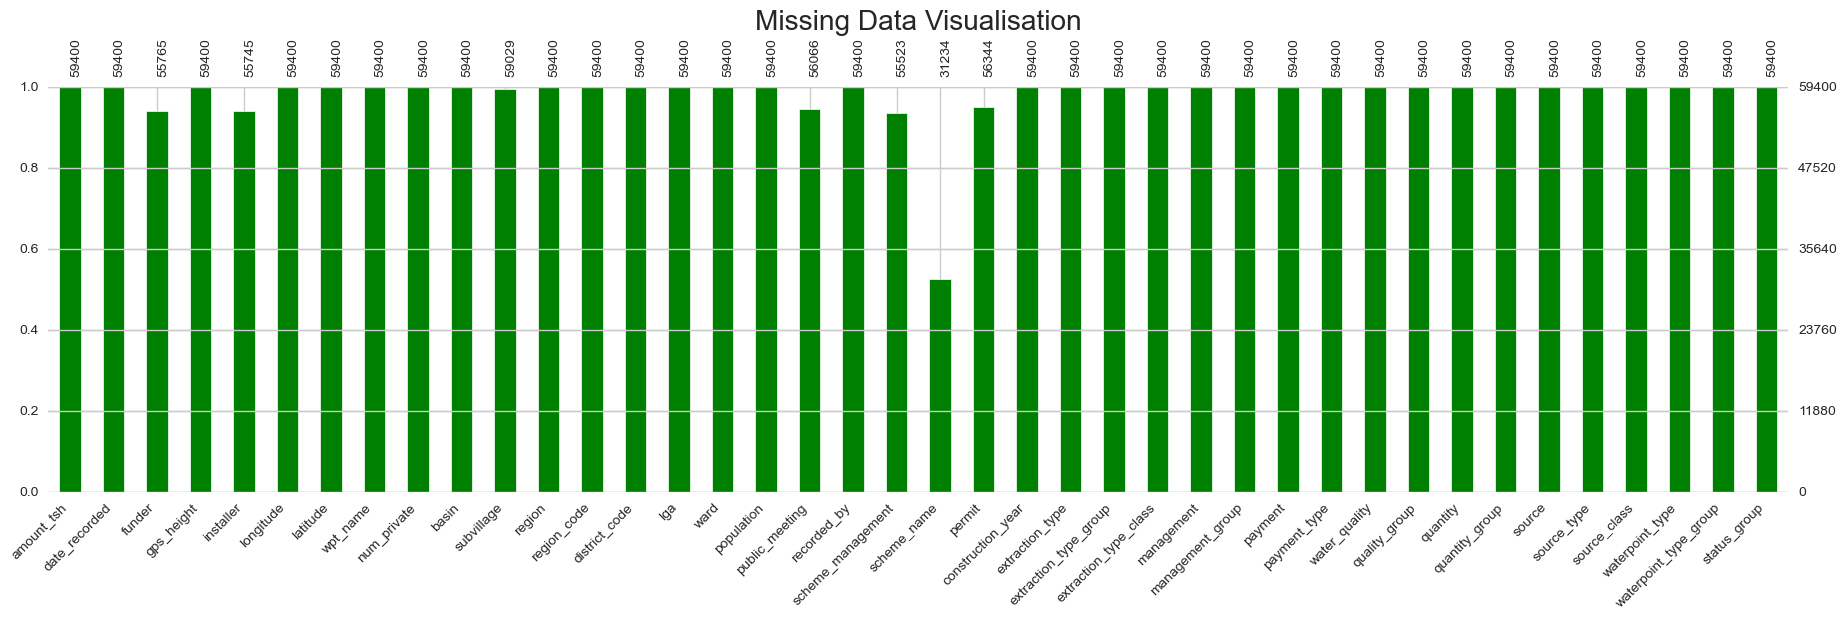

In [74]:
# Visualise the missing data in the DataFrame | Fix the visualisation
msno.bar(data, figsize=(20, 5), fontsize=(10), color='green')
plt.title("Missing Data Visualisation")
plt.xticks(rotation = 90, fontsize=10);

In [45]:
# Describe the numerical data
data.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## 3. Data Preparation
> This phase, which is often referred to as “data munging”, prepares the final data set(s) for modeling. It has five tasks:
> - Select Data
> - Clean Data
> - Construct Data
> - Integrate Data
> - Format Data

### 3.1 Select Data
> In this section, we determine which data sets will be used and document reasons for inclusion/exclusion.